# Example of using the crack classification model as a service with REST API

In [1]:
import requests
import json
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy

Service provider configuration:

In [2]:
HOSTNAME="localhost"
#MODEL="simplenet_cracks8020"
MODEL="febrero-cpu-friendly_weights"
ENDPOINT='http://%s:8501/v1/models/%s' % (HOSTNAME, MODEL)

## API usage

### Query service status

In [3]:
r = requests.get(ENDPOINT)
r.json()

{'model_version_status': [{'state': 'AVAILABLE',
   'status': {'error_code': 'OK', 'error_message': ''},
   'version': '1'}]}

### Query model metadata

In [4]:
r = requests.get(ENDPOINT+"/metadata")
r.json()

{'metadata': {'signature_def': {'signature_def': {'serving_default': {'inputs': {'input_image': {'dtype': 'DT_FLOAT',
       'name': 'conv2d_11_input:0',
       'tensor_shape': {'dim': [{'name': '', 'size': '-1'},
         {'name': '', 'size': '64'},
         {'name': '', 'size': '64'},
         {'name': '', 'size': '3'}],
        'unknown_rank': False}}},
     'method_name': 'tensorflow/serving/predict',
     'outputs': {'dense_12/Softmax:0': {'dtype': 'DT_FLOAT',
       'name': 'dense_12/Softmax:0',
       'tensor_shape': {'dim': [{'name': '', 'size': '-1'},
         {'name': '', 'size': '2'}],
        'unknown_rank': False}}}}}}},
 'model_spec': {'name': 'febrero-cpu-friendly_weights',
  'signature_name': '',
  'version': '1'}}

Metadata is used to obtain the input image parameters for the service

In [5]:
INPUT_IMAGE_WIDTH = int(r.json()['metadata']['signature_def']['signature_def']['serving_default']['inputs']['input_image']['tensor_shape']['dim'][1]['size'])
INPUT_IMAGE_HEIGHT = int(r.json()['metadata']['signature_def']['signature_def']['serving_default']['inputs']['input_image']['tensor_shape']['dim'][2]['size'])
print(INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)

64 64


### Make a single prediction

Load a local image using OpenCV and resize it to the input required by the served model.

In [6]:
def load_local_image(img_filename, w,h):
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix color order (depends on OpenCV version)
    return cv2.resize(img,(int(w),int(h))) 

Method to make a prediction

In [7]:
def predict_crack_or_no_crack(img):
    r = requests.post(ENDPOINT+':predict', json={"instances": [{'input_image': img.tolist()}]})
    
    result = {
        "no_crack_prob": r.json()['predictions'][0][0],
        "crack_prob": r.json()['predictions'][0][1]
    }
    return result

Method to collect random images from dataset

In [8]:
def pick_random_files(n_files, path, class_names):
    image_files = []
    for name in class_names:
        tmp=os.listdir(path+name)
        for i in range(int(n_files/len(class_names))):
            image_files.append(path+name+"/"+random.choice(tmp))
    random.shuffle(image_files)
    return image_files

In [9]:
IMG_PATH="/tf/notebooks/data/datasets/cracks_splitted8020/test_set/"
N_TEST_IMAGES = 16
CLASS_NAMES = ["Negative","Positive"]

image_files = pick_random_files(N_TEST_IMAGES, IMG_PATH,CLASS_NAMES )

Test a single prediction

In [10]:
img = load_local_image(image_files[0],INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
r = requests.post(ENDPOINT+':predict', json={"instances": [{'input_image': img.tolist()}]})

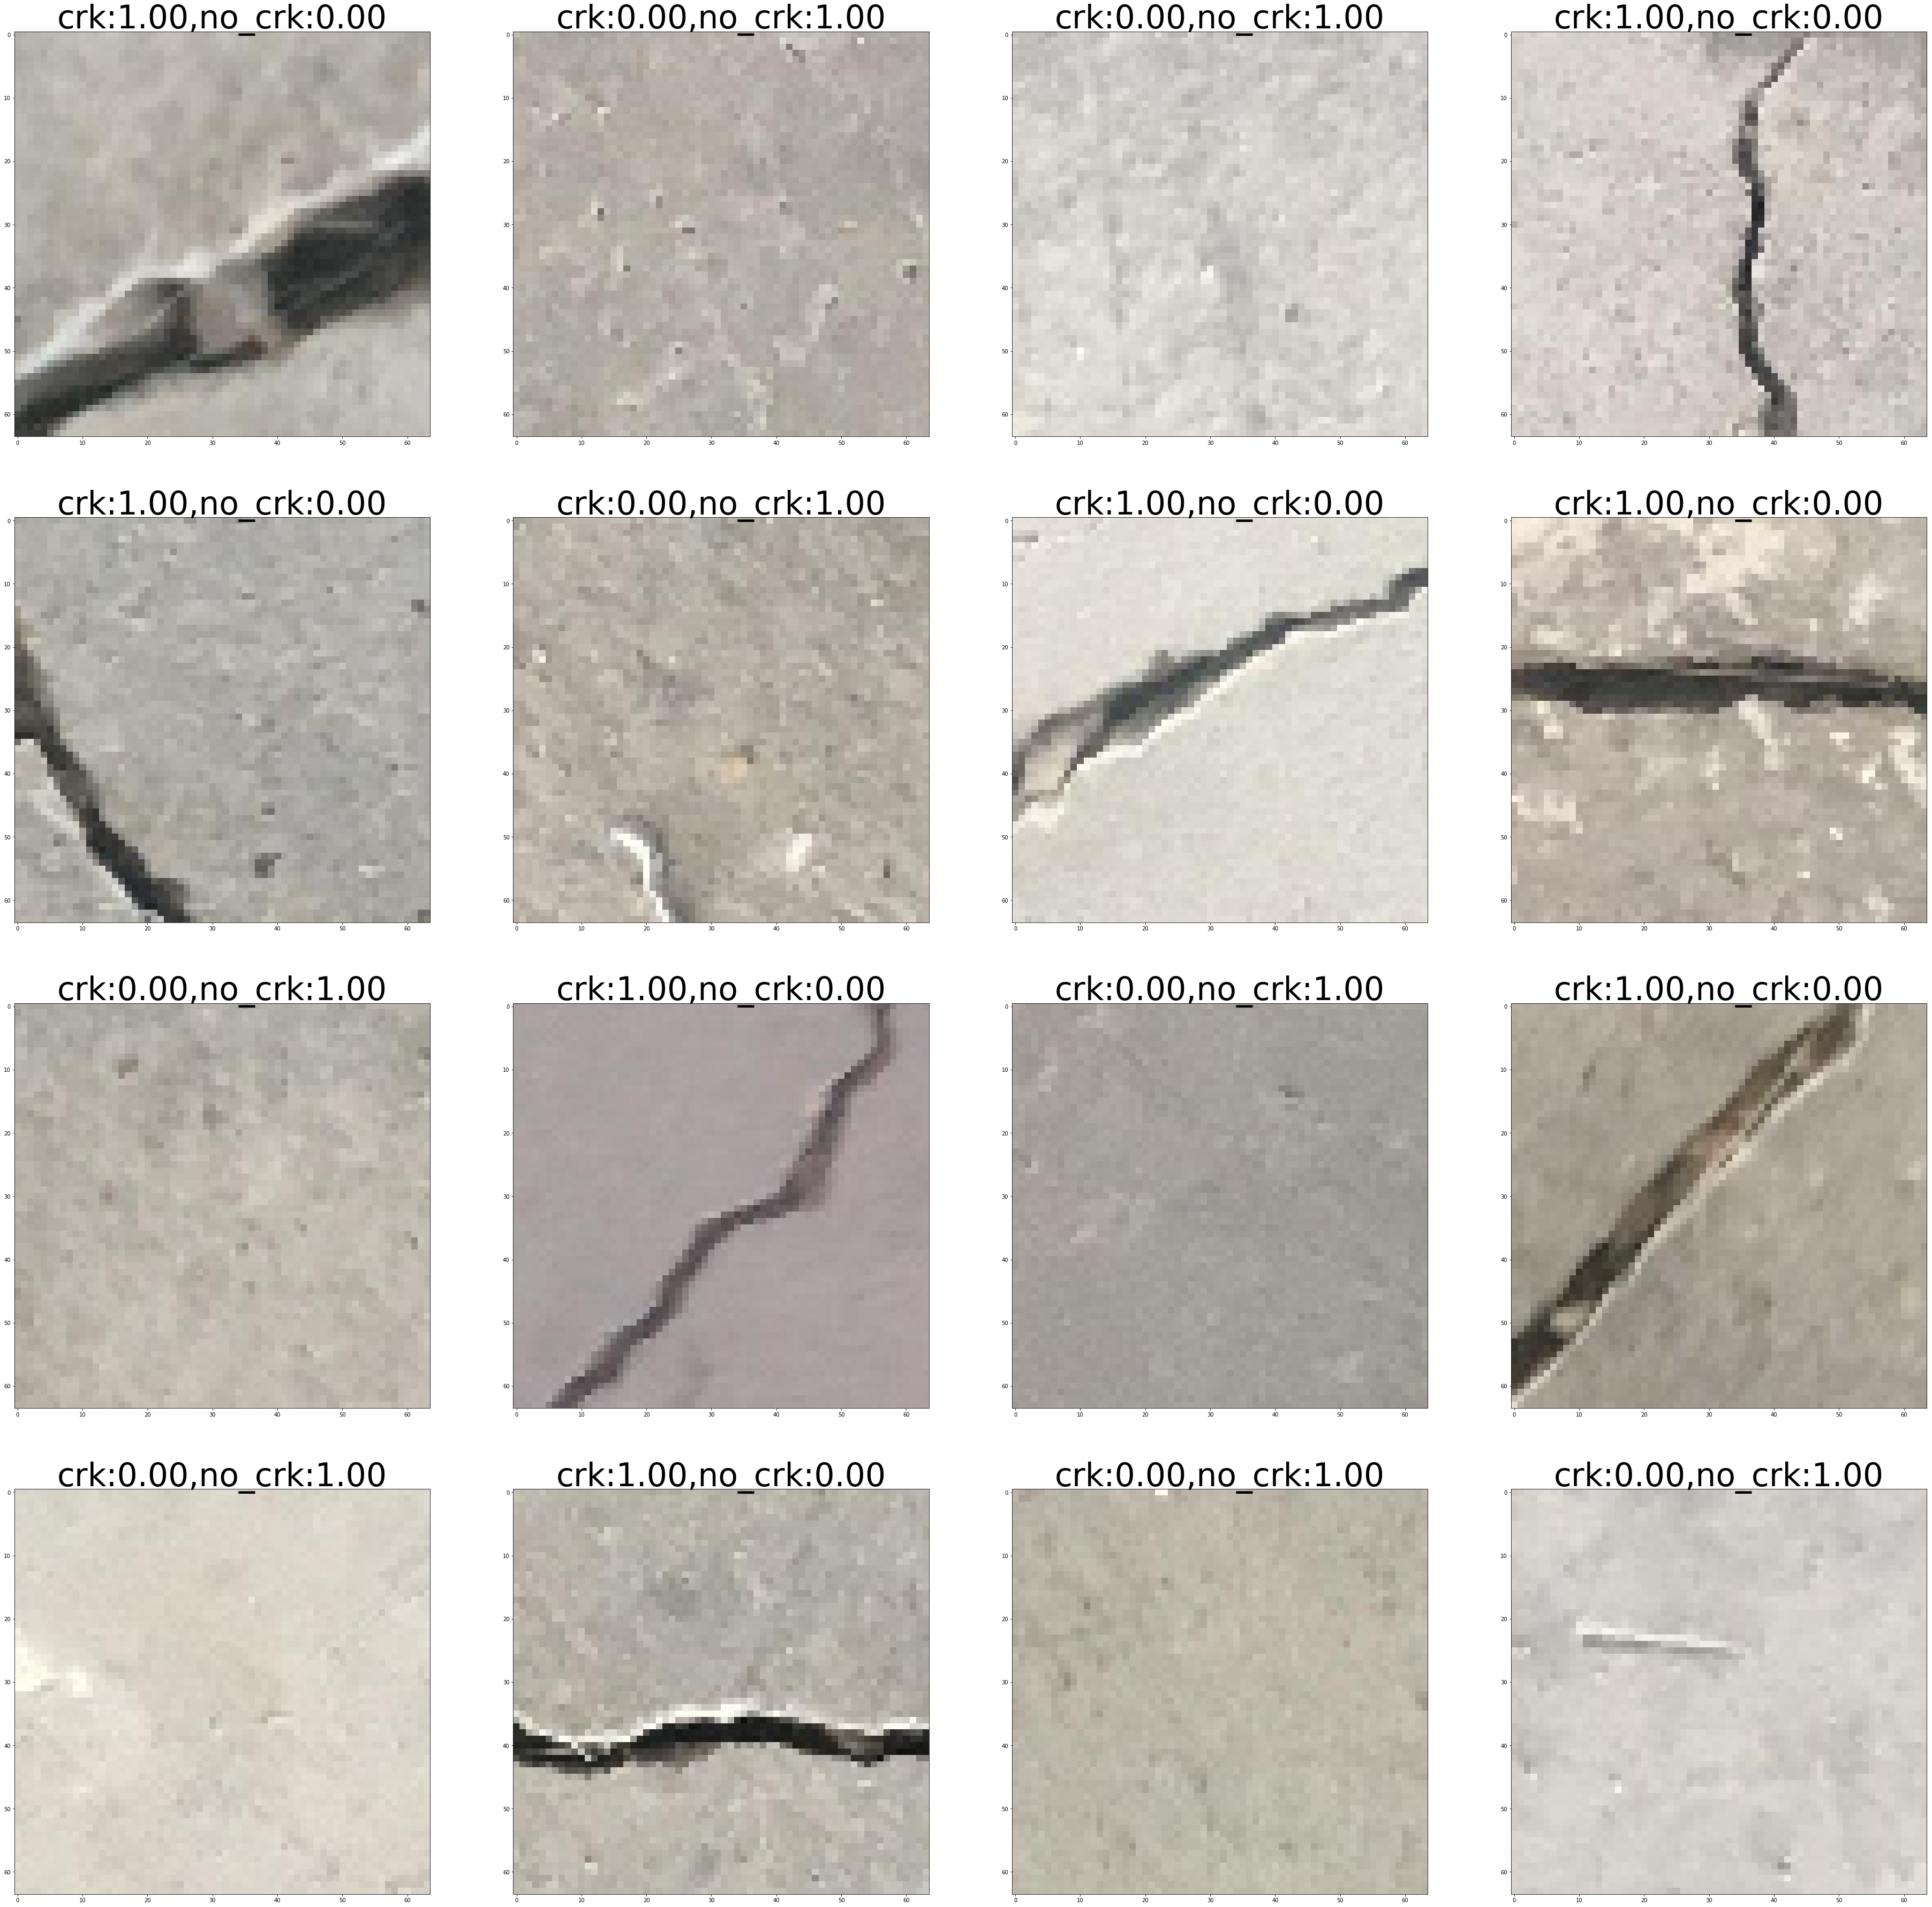

In [11]:
fig=plt.figure(figsize=(64, 64))
n_columns = 4
n_rows = N_TEST_IMAGES/n_columns
i = 1
for img_filename in image_files:
    img = load_local_image(img_filename,INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT)
    fig.add_subplot(n_rows, n_columns, i)
    plt.imshow(img, interpolation='nearest', aspect='auto')
    pred = predict_crack_or_no_crack(img)
    plt.title("crk:%0.2f,no_crk:%0.2f" % (pred["crack_prob"],pred["no_crack_prob"],), fontsize=60)
    i = i + 1
plt.show()

### Scan a large image in search for ROIs

Example of how to scan a large image in search of ROIs that may contain a crack. Original image is from: [Grieta en la Antártica](https://prensaantartica.com/2016/09/11/nasa-descubre-enorme-grieta-que-avanza-en-plataforma-de-hielo-en-la-antartica/).
<img src="../../../data/media/nasa-antartica.jpg">

Definition of a method that scans a large image and executes the classifier for overlapping cells that match the classifier input size.

In [12]:
def scan_image(img,cell_width,cell_height,stride_x,stride_y):
    boxes = []
    
    for x0 in range(0,int(img.shape[1])-cell_width,stride_x):
        for y0 in range(0,int(img.shape[0])-cell_height,stride_y):            
            x1 = x0 + cell_width
            y1 = y0 + cell_height
            subimg = img[y0:y1,x0:x1]                
            subimg_converted = subimg.reshape(1,cell_width,cell_height,3) 
            pred = predict_crack_or_no_crack(subimg)
            if numpy.isclose(pred["crack_prob"], 1, rtol=1e-05, atol=1e-08, equal_nan=False):
                boxes.append((x0,y0,x1,y1))
    return boxes 

In [13]:
IMAGE_FILENAME="../../data/media/nasa-antartica.jpg"    
    
img = cv2.imread(IMAGE_FILENAME)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix color order (depends on OpenCV version)

boxes = scan_image(img,cell_width=INPUT_IMAGE_WIDTH,cell_height=INPUT_IMAGE_HEIGHT,stride_x=16,stride_y=16)

In [14]:
def draw_found_bounding_boxes(img, boxes,color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(img, box[0:2], box[2:4], color, 4)
        

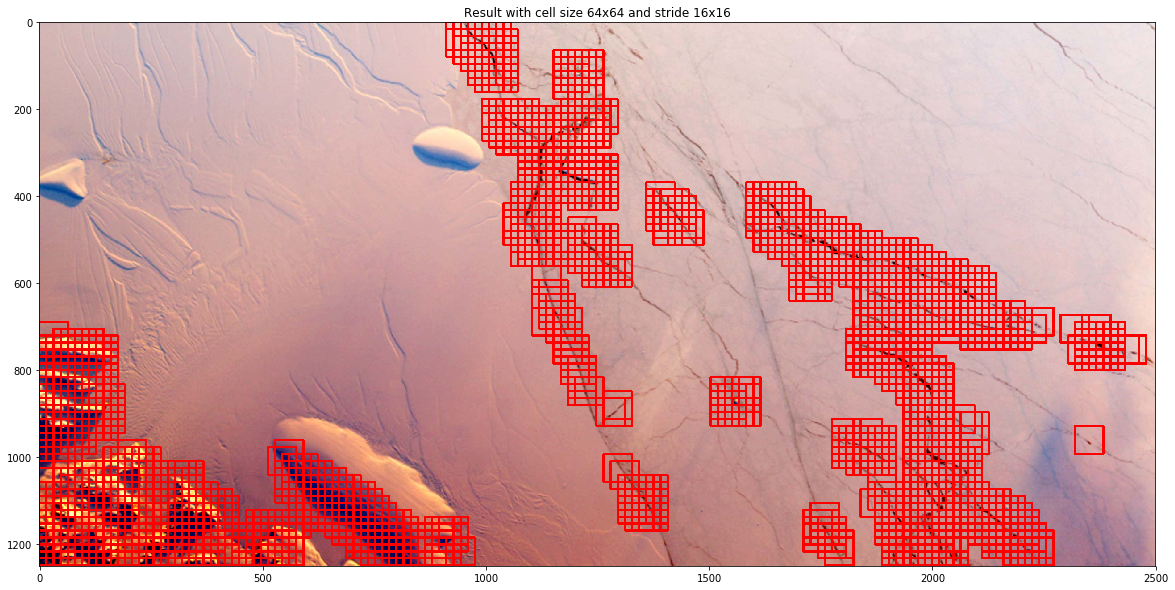

In [15]:
img = cv2.imread(IMAGE_FILENAME)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # fix color order (depends on OpenCV version)
draw_found_bounding_boxes(img,boxes)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(img, interpolation='nearest', aspect='auto')
plt.title("Result with cell size %dx%d and stride %dx%d" % (INPUT_IMAGE_WIDTH,INPUT_IMAGE_HEIGHT,16,16))
plt.show()